In [20]:
import torch
import numpy
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
from torch.utils.data import Dataset
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [96]:
import os
import pandas as pd
import random
import json
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.length = self.labels.shape[0]
        self.size = 100
        self.images = []
        self.annotations = []
        for idx in range(self.length):
            assert idx < len(self.labels)
            img_path = os.path.join(self.img_dir, self.labels.iloc[idx, 0] + '.jpg')
            pic = cv2.imread(img_path)
            b, g, r = cv2.split(pic) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
            self.images.append(cv2.merge([r, g, b]))
            self.annotations.append(json.load(open(self.labels.iloc[idx, 0] + '.json', 'r')))
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        random.seed(idx)
        idx = random.choice(range(self.length))
        img = self.images[idx]
        l = random.randint(0, img.shape[0] - self.size)
        t = random.randint(0, img.shape[1] - self.size)
        img_crop = img[l:l + self.size, t:t+ self.size]
        label = self.annotations[idx]
#         print(label)
        return img_crop, label, l, t

In [97]:
dataset = CustomImageDataset('annotations.csv', '.')

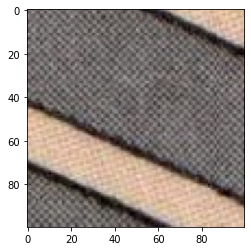

In [98]:
pic = dataset[0][0]
plt.imshow(pic)

In [99]:
# points = []
# def make_points(pic):
#     global points
#     points = []
#     for line in pic:
#         for element in line:
#             points.append(element)
# make_points()

In [100]:
from sklearn.cluster import DBSCAN, KMeans
import numpy as np
import torch.optim as optim
# def drawKmeans(pic, points, clusters=10):
#     model = KMeans(n_clusters=clusters).fit(points)
#     res = [(0, 0, 0) for x in points]
#     color = [(int(a), int(b), int(c)) for a, b, c in model.cluster_centers_]
#     for i in range(len(points)):
#         res[i] = color[model.labels_[i]]
#     res = np.array(res)
#     res = res.reshape((pic.shape[0], pic.shape[1], pic.shape[2]))
#     return res
#     plt.imshow(res)
#     cv2.imwrite(name + '_kmeans_' + str(clusters) + '.png', res)
#     if ret:
#         return res.reshape((img.shape[0] * img.shape[1], img.shape[2]))

In [101]:
def prepare(pic):
    res = pic / 255
#     points = []
#     for line in pic:
#         for element in line:
#             points.append(element)
#     clusters=10
#     model = KMeans(n_clusters=clusters).fit(points)
#     res = [(0, 0, 0) for x in points]
#     color = [(a, b, c) for a, b, c in model.cluster_centers_]
#     for i in range(len(points)):
#         res[i] = color[model.labels_[i]]
#     res = np.array(res)
#     res = res.reshape((pic.shape[0], pic.shape[1], pic.shape[2]))
#     assert res.shape[0] * res.shape[1] * res.shape[2] == pic.shape[0] * pic.shape[1] * pic.shape[2] 
    return res

In [150]:
model = nn.Sequential(
    nn.Conv2d(3, 5, 3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d((2, 2)),
    nn.Conv2d(5, 5, 3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d((2, 2)),
    nn.Conv2d(5, 5, 3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d((2, 2)),
    nn.Conv2d(5, 5, 3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d((2, 2)),
    nn.Conv2d(5, 5, 3,padding=1),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.Conv2d(5, 5, 3,padding=1),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.Conv2d(5, 5, 3,padding=1),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.Conv2d(5, 5, 3,padding=2),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.Conv2d(5, 1, 3, padding=1),
    nn.Sigmoid()
)

In [127]:
# model = torch.load('model.pt')

In [128]:
def classnum(shape):
    return 1
    if shape['label'] == 'fence':
        return 1
    if shape['label'] == 'forbidden':
        return 1
    if shape['label'] == 'building':
        return 1
    return shape['label']

def vec(x0, y0, x1, y1):
    return x0 * y1 - x1 * y0

def calc_vec(a, b, c):
    return vec(b[0] - a[0], b[1] - a[1], c[0] - a[0], c[1] - a[1])

def intersec(a, b, c, d):
    return calc_vec(a, b, c) * calc_vec(a, b, d) < 0 and calc_vec(c, d, b) * calc_vec(c, d, a) < 0

In [105]:
assert intersec((0, 0), (1, 1), (0, 1), (1, 0)) == True
assert intersec((0, 0), (1, 1), (0.6, 0.4), (1, 0)) == False

In [106]:
import math
from tqdm import tqdm
def detect(x, y, shape):
    if shape['shape_type'] == 'Line':
        v0, v1 = shape['points']
        a = v1[1] - v0[1]
        b = v0[0] - v1[0]
        c = -(v1[0] * a + v1[1] * b)
        if a ** 2 + b ** 2 == 0:
            return False
        d = (a * x + b * y + c) / math.sqrt(a ** 2 + b ** 2)
        between = ((x - v0[0]) * (v1[0] - v0[0]) + (y - v0[1]) * (v1[1] - v0[1]) ) >= 0 and ((x - v1[0]) * (v0[0] - v1[0]) + (y - v1[1]) * (v0[1] - v1[1]) ) >= 0
        return abs(d) < 3 and between
    if shape['shape_type'].startswith('line'):
        for i in range(len(shape['points']) - 1):
            line = {'points': [shape['points'][i], shape['points'][i + 1]],
                    'shape_type': 'Line'}
            if detect(x, y, line):
                return True
        return False
    if shape['shape_type'] == 'polygon':
        s = 0
        other = [10002.7, 10000.5] 
        for i in range(len(shape['points'])):
            point = shape['points'][i]
            next_point = shape['points'][(i + 1) % len(shape['points'])]
            if intersec([x, y], other, point, next_point):
                s += 1
        if s % 2 != 0:
#             print(x, y, s, shape)
            return True
        return False
    return False
            

def create_Xy(sz=20):
    labels = []
    data = []
    for label_id in tqdm(range(sz)):
        labels.append([])
        labels[-1].append([])
        pic, annotation, l, t = dataset[label_id]
        data.append(prepare(pic))
        for i in range(dataset.size):
            labels[-1][-1].append([])
            for j in range(dataset.size):
                labels[-1][-1][-1].append(0)
                for shape in annotation['shapes']:
                    if detect(j + t, i + l, shape):
                        labels[-1][-1][-1][-1] = float(classnum(shape))
                        break
    data_tensor = torch.tensor(np.array(data, dtype=float)).permute(0, 3, 1, 2).float()
    labels_tensor = torch.tensor(labels)
    return data_tensor, labels_tensor

In [90]:
X, y = create_Xy(2)

100%|██████████| 2/2 [00:12<00:00,  6.35s/it]


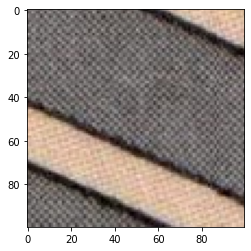

In [91]:
plt.imshow(X[0].permute(1, 2, 0).detach().numpy())

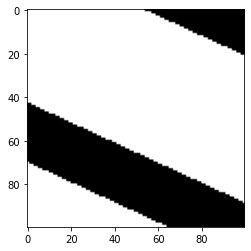

In [92]:
plt.imshow(y[0][0], cmap='gray')

In [109]:
data_size = 200

In [110]:
# _x = torch.load('X.pt')
# _y = torch.load('y.pt')
# learn_data = _x, _y

In [111]:
learn_data = create_Xy(data_size)

100%|██████████| 200/200 [36:23<00:00, 10.92s/it] 


In [112]:
torch.save(learn_data[0], 'X.pt')

In [113]:
torch.save(learn_data[1], 'y.pt')

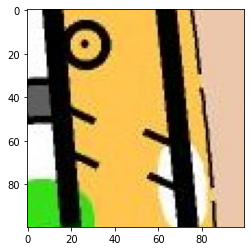

In [114]:
plt.imshow(learn_data[0].permute(0, 2, 3, 1).detach().numpy()[-1])

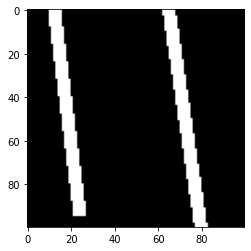

In [115]:
plt.imshow(learn_data[1][-1][0].detach().numpy(), cmap='gray')

In [53]:
# test_data = create_Xy(1)

In [151]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [156]:
batch_size = 32
for epoch in range(10 * 300):
    cur_loss = 0
    for batch in range((data_size + batch_size - 1) // batch_size):
        X, y = learn_data
        X = X[batch * batch_size : (batch + 1) * batch_size]
        y = y[batch * batch_size : (batch + 1) * batch_size]
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        cur_loss += loss.item() / batch_size * len(X)
    if epoch % 10 == 0:
        print(cur_loss)

0.9090435653924942
0.9063898995518684
1.0124419704079628
0.93379145860672
0.8833007626235485
0.9031875617802143
0.8830745182931423
0.8831242583692074
0.926021508872509
0.9848025403916836
0.9005575478076935
0.8720609657466412
0.9385490193963051
0.9211336225271225
0.9634157866239548
0.8887034319341183
0.9395466595888138
1.0110491886734962
0.9693643003702164
0.9442377761006355
0.8907176442444324
1.0277773290872574
1.0096648707985878
0.9167987294495106
0.9171798452734947
0.8964278660714626
0.9142250046133995
0.8967486061155796
0.8975350111722946
0.864137165248394
0.9847257807850838
0.8945297040045261
0.8853731639683247
0.8998238481581211
1.2722335755825043
1.2099742144346237
0.9063649512827396
0.8932192511856556
0.8867348060011864
0.8630714192986488
0.8762803375720978
0.8551218584179878
1.0082888044416904
0.9105763249099255
0.9229818470776081
0.9012493081390858
0.9288521260023117
0.8857027739286423
0.9807700626552105
1.0636435523629189
0.9310673587024212
0.8935288973152637
0.94269346818327

In [157]:
torch.save(model, 'model.pt')

In [158]:
sample_size = 10
sample_data_X, sample_data_y = learn_data
sample_data_predicted = model(sample_data_X)

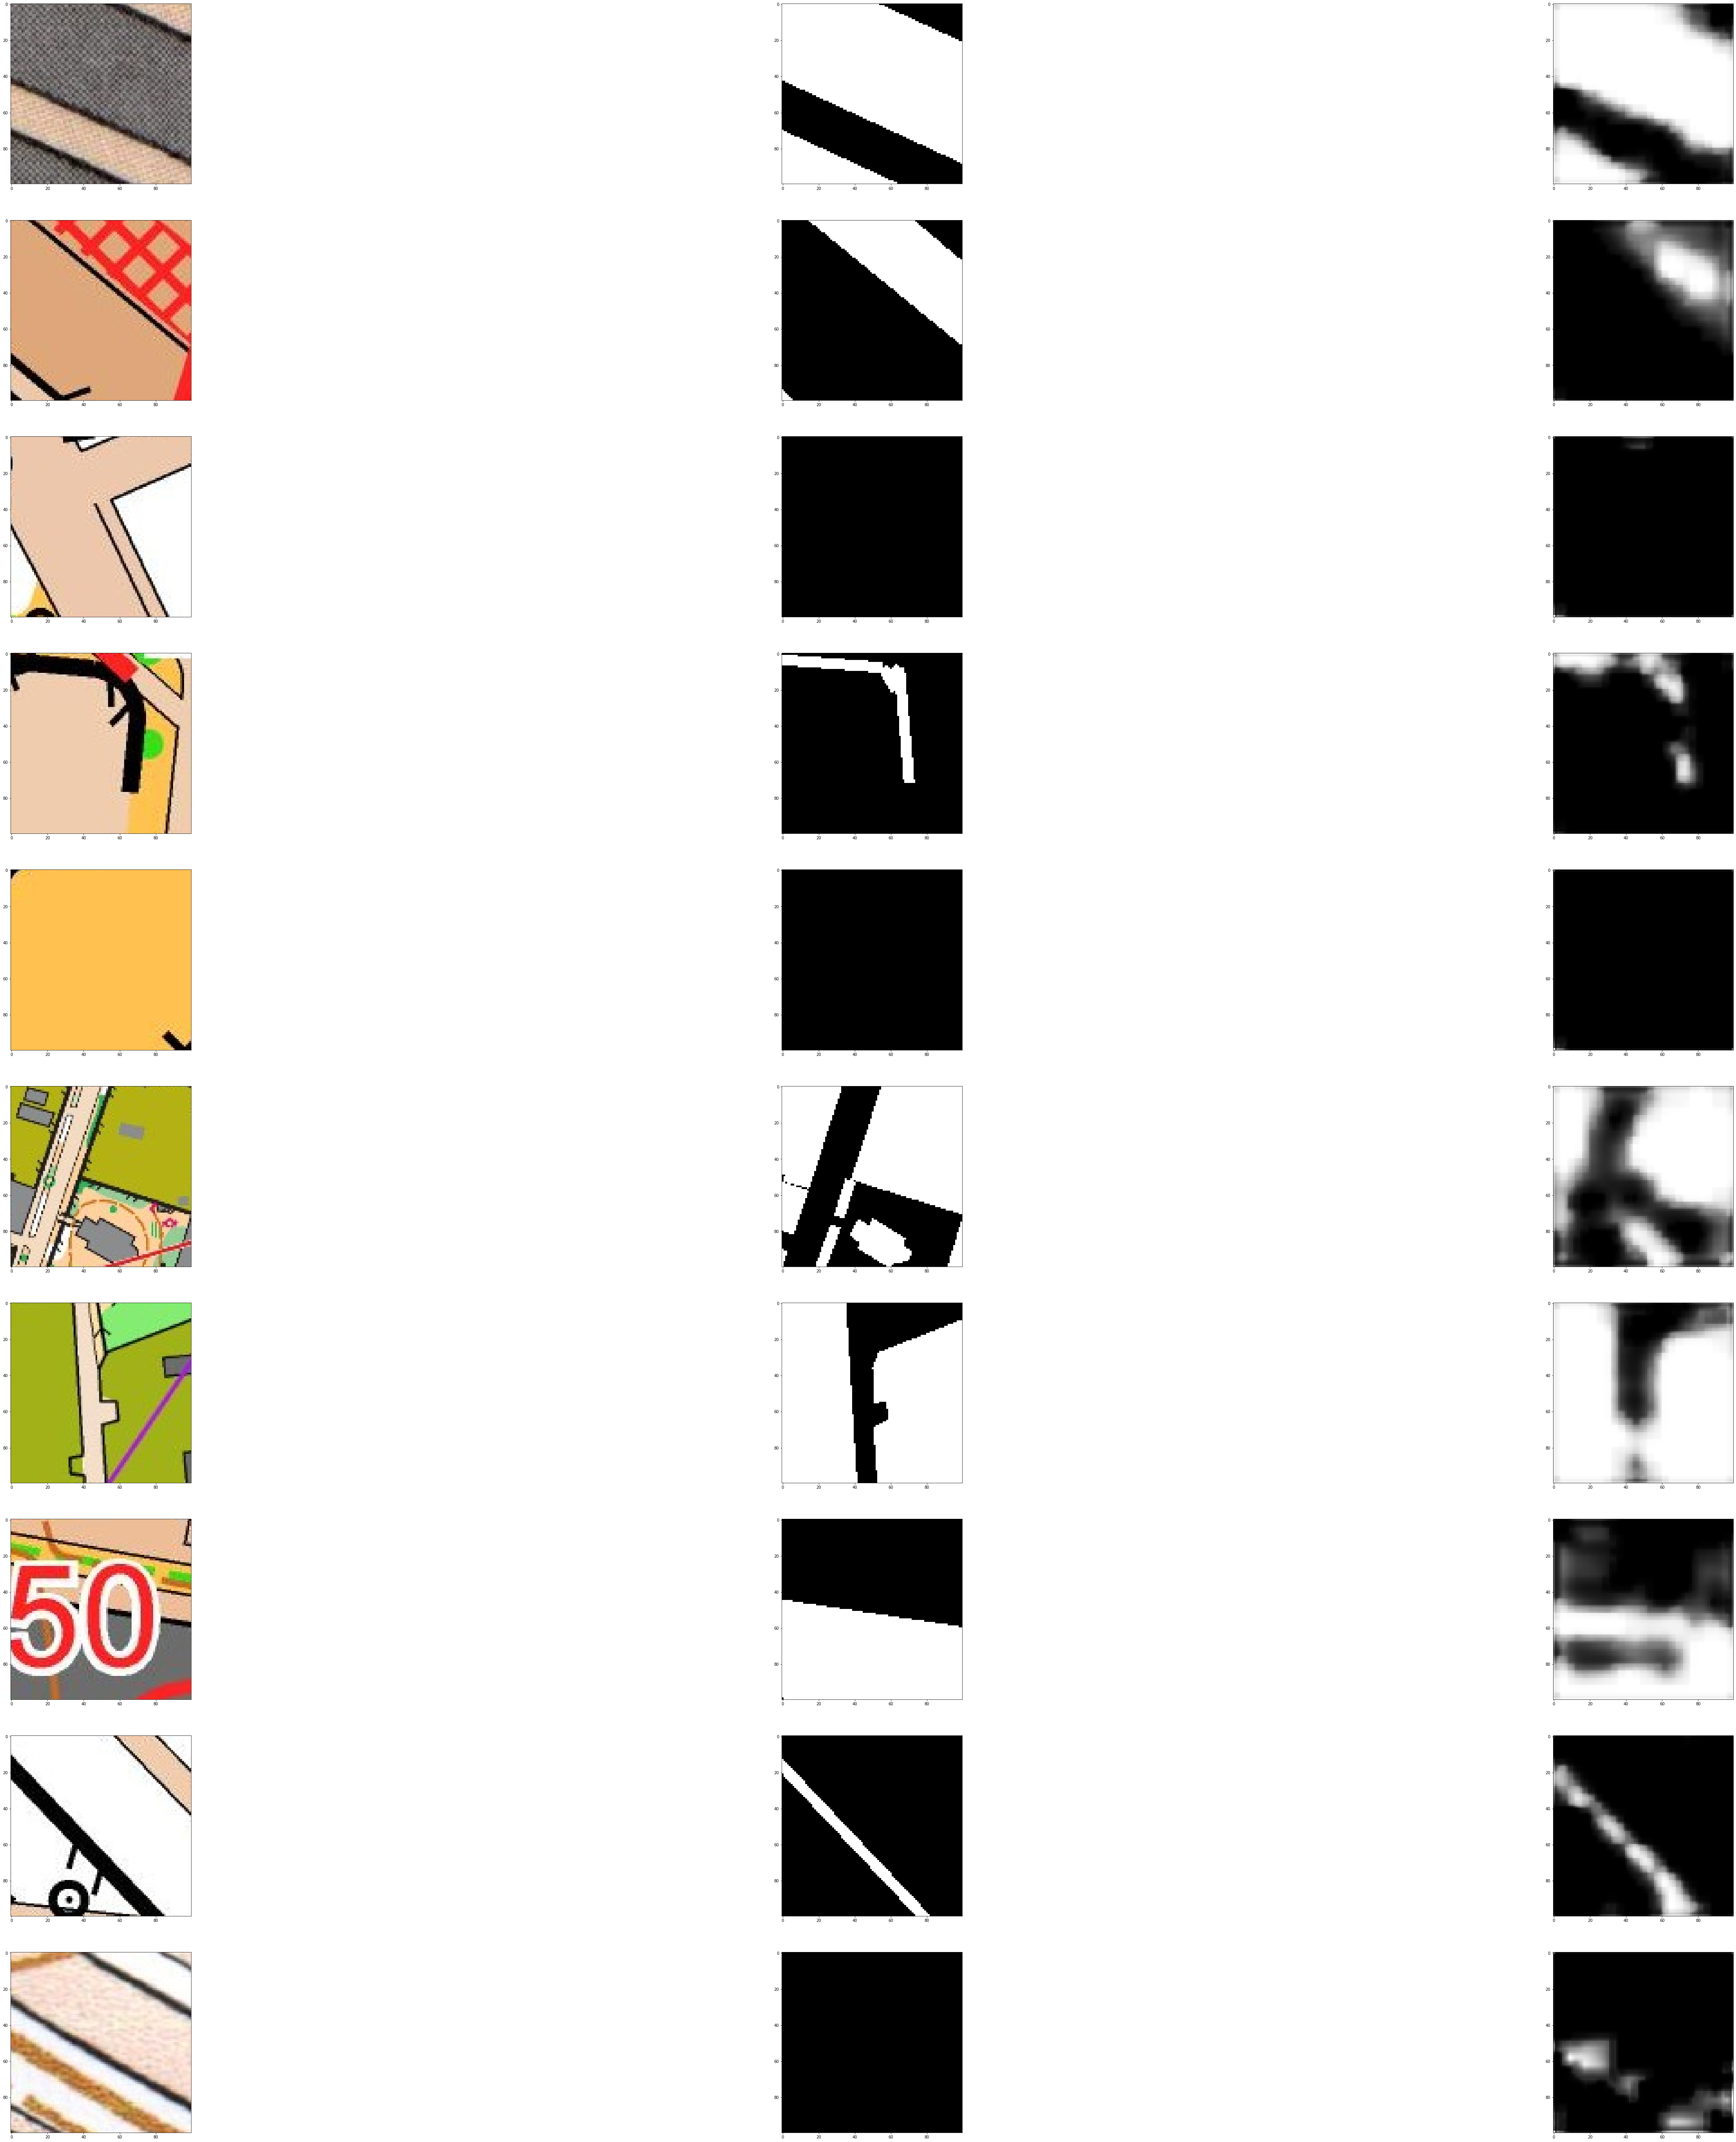

In [159]:
fig = plt.figure(figsize=(100, 100))
for i in range(sample_size):
    fig.add_subplot(sample_size, 3, 3 * i + 1)
    plt.imshow(sample_data_X[i].permute(1, 2, 0).detach().numpy())
    fig.add_subplot(sample_size, 3, 3 * i + 2)
    plt.imshow(sample_data_y[i][0], cmap='gray')
    fig.add_subplot(sample_size, 3, 3 * i + 3)
    plt.imshow(sample_data_predicted[i][0].detach().numpy(), cmap='gray')
plt.show()

In [160]:
sample_data_y.shape, sample_data_predicted.shape

(torch.Size([200, 1, 100, 100]), torch.Size([200, 1, 100, 100]))

In [161]:
sample_data_predicted[1]

tensor([[[0.1101, 0.0132, 0.0132,  ..., 0.1706, 0.1432, 0.3589],
         [0.0170, 0.0012, 0.0012,  ..., 0.0496, 0.0400, 0.1690],
         [0.0170, 0.0012, 0.0012,  ..., 0.0500, 0.0453, 0.1998],
         ...,
         [0.1556, 0.0365, 0.0590,  ..., 0.0012, 0.0012, 0.0169],
         [0.1246, 0.0281, 0.0530,  ..., 0.0012, 0.0012, 0.0169],
         [0.3473, 0.1111, 0.1748,  ..., 0.0140, 0.0140, 0.1158]]],
       grad_fn=<SelectBackward>)

0  /  1929
1  /  1929
2  /  1929
3  /  1929
4  /  1929
5  /  1929
6  /  1929
7  /  1929
8  /  1929
9  /  1929
10  /  1929
11  /  1929
12  /  1929
13  /  1929
14  /  1929
15  /  1929
16  /  1929
17  /  1929
18  /  1929
19  /  1929
20  /  1929
21  /  1929
22  /  1929
23  /  1929
24  /  1929
25  /  1929
26  /  1929
27  /  1929
28  /  1929
29  /  1929
30  /  1929
31  /  1929
32  /  1929
33  /  1929
34  /  1929
35  /  1929
36  /  1929
37  /  1929
38  /  1929
39  /  1929
40  /  1929
41  /  1929
42  /  1929
43  /  1929
44  /  1929
45  /  1929
46  /  1929
47  /  1929
48  /  1929
49  /  1929
50  /  1929
51  /  1929
52  /  1929
53  /  1929
54  /  1929
55  /  1929
56  /  1929
57  /  1929
58  /  1929
59  /  1929
60  /  1929
61  /  1929
62  /  1929
63  /  1929
64  /  1929
65  /  1929
66  /  1929
67  /  1929
68  /  1929
69  /  1929
70  /  1929
71  /  1929
72  /  1929
73  /  1929
74  /  1929
75  /  1929
76  /  1929
77  /  1929
78  /  1929
79  /  1929
80  /  1929
81  /  1929
82  /  1929
83  /  1929
84

639  /  1929
640  /  1929
641  /  1929
642  /  1929
643  /  1929
644  /  1929
645  /  1929
646  /  1929
647  /  1929
648  /  1929
649  /  1929
650  /  1929
651  /  1929
652  /  1929
653  /  1929
654  /  1929
655  /  1929
656  /  1929
657  /  1929
658  /  1929
659  /  1929
660  /  1929
661  /  1929
662  /  1929
663  /  1929
664  /  1929
665  /  1929
666  /  1929
667  /  1929
668  /  1929
669  /  1929
670  /  1929
671  /  1929
672  /  1929
673  /  1929
674  /  1929
675  /  1929
676  /  1929
677  /  1929
678  /  1929
679  /  1929
680  /  1929
681  /  1929
682  /  1929
683  /  1929
684  /  1929
685  /  1929
686  /  1929
687  /  1929
688  /  1929
689  /  1929
690  /  1929
691  /  1929
692  /  1929
693  /  1929
694  /  1929
695  /  1929
696  /  1929
697  /  1929
698  /  1929
699  /  1929
700  /  1929
701  /  1929
702  /  1929
703  /  1929
704  /  1929
705  /  1929
706  /  1929
707  /  1929
708  /  1929
709  /  1929
710  /  1929
711  /  1929
712  /  1929
713  /  1929
714  /  1929
715  /  1929

1250  /  1929
1251  /  1929
1252  /  1929
1253  /  1929
1254  /  1929
1255  /  1929
1256  /  1929
1257  /  1929
1258  /  1929
1259  /  1929
1260  /  1929
1261  /  1929
1262  /  1929
1263  /  1929
1264  /  1929
1265  /  1929
1266  /  1929
1267  /  1929
1268  /  1929
1269  /  1929
1270  /  1929
1271  /  1929
1272  /  1929
1273  /  1929
1274  /  1929
1275  /  1929
1276  /  1929
1277  /  1929
1278  /  1929
1279  /  1929
1280  /  1929
1281  /  1929
1282  /  1929
1283  /  1929
1284  /  1929
1285  /  1929
1286  /  1929
1287  /  1929
1288  /  1929
1289  /  1929
1290  /  1929
1291  /  1929
1292  /  1929
1293  /  1929
1294  /  1929
1295  /  1929
1296  /  1929
1297  /  1929
1298  /  1929
1299  /  1929
1300  /  1929
1301  /  1929
1302  /  1929
1303  /  1929
1304  /  1929
1305  /  1929
1306  /  1929
1307  /  1929
1308  /  1929
1309  /  1929
1310  /  1929
1311  /  1929
1312  /  1929
1313  /  1929
1314  /  1929
1315  /  1929
1316  /  1929
1317  /  1929
1318  /  1929
1319  /  1929
1320  /  1929
1321  

1836  /  1929
1837  /  1929
1838  /  1929
1839  /  1929
1840  /  1929
1841  /  1929
1842  /  1929
1843  /  1929
1844  /  1929
1845  /  1929
1846  /  1929
1847  /  1929
1848  /  1929
1849  /  1929
1850  /  1929
1851  /  1929
1852  /  1929
1853  /  1929
1854  /  1929
1855  /  1929
1856  /  1929
1857  /  1929
1858  /  1929
1859  /  1929
1860  /  1929
1861  /  1929
1862  /  1929
1863  /  1929
1864  /  1929
1865  /  1929
1866  /  1929
1867  /  1929
1868  /  1929
1869  /  1929
1870  /  1929
1871  /  1929
1872  /  1929
1873  /  1929
1874  /  1929
1875  /  1929
1876  /  1929
1877  /  1929
1878  /  1929
1879  /  1929
1880  /  1929
1881  /  1929
1882  /  1929
1883  /  1929
1884  /  1929
1885  /  1929
1886  /  1929
1887  /  1929
1888  /  1929
1889  /  1929
1890  /  1929
1891  /  1929
1892  /  1929
1893  /  1929
1894  /  1929
1895  /  1929
1896  /  1929
1897  /  1929
1898  /  1929
1899  /  1929
1900  /  1929
1901  /  1929
1902  /  1929
1903  /  1929
1904  /  1929
1905  /  1929
1906  /  1929
1907  

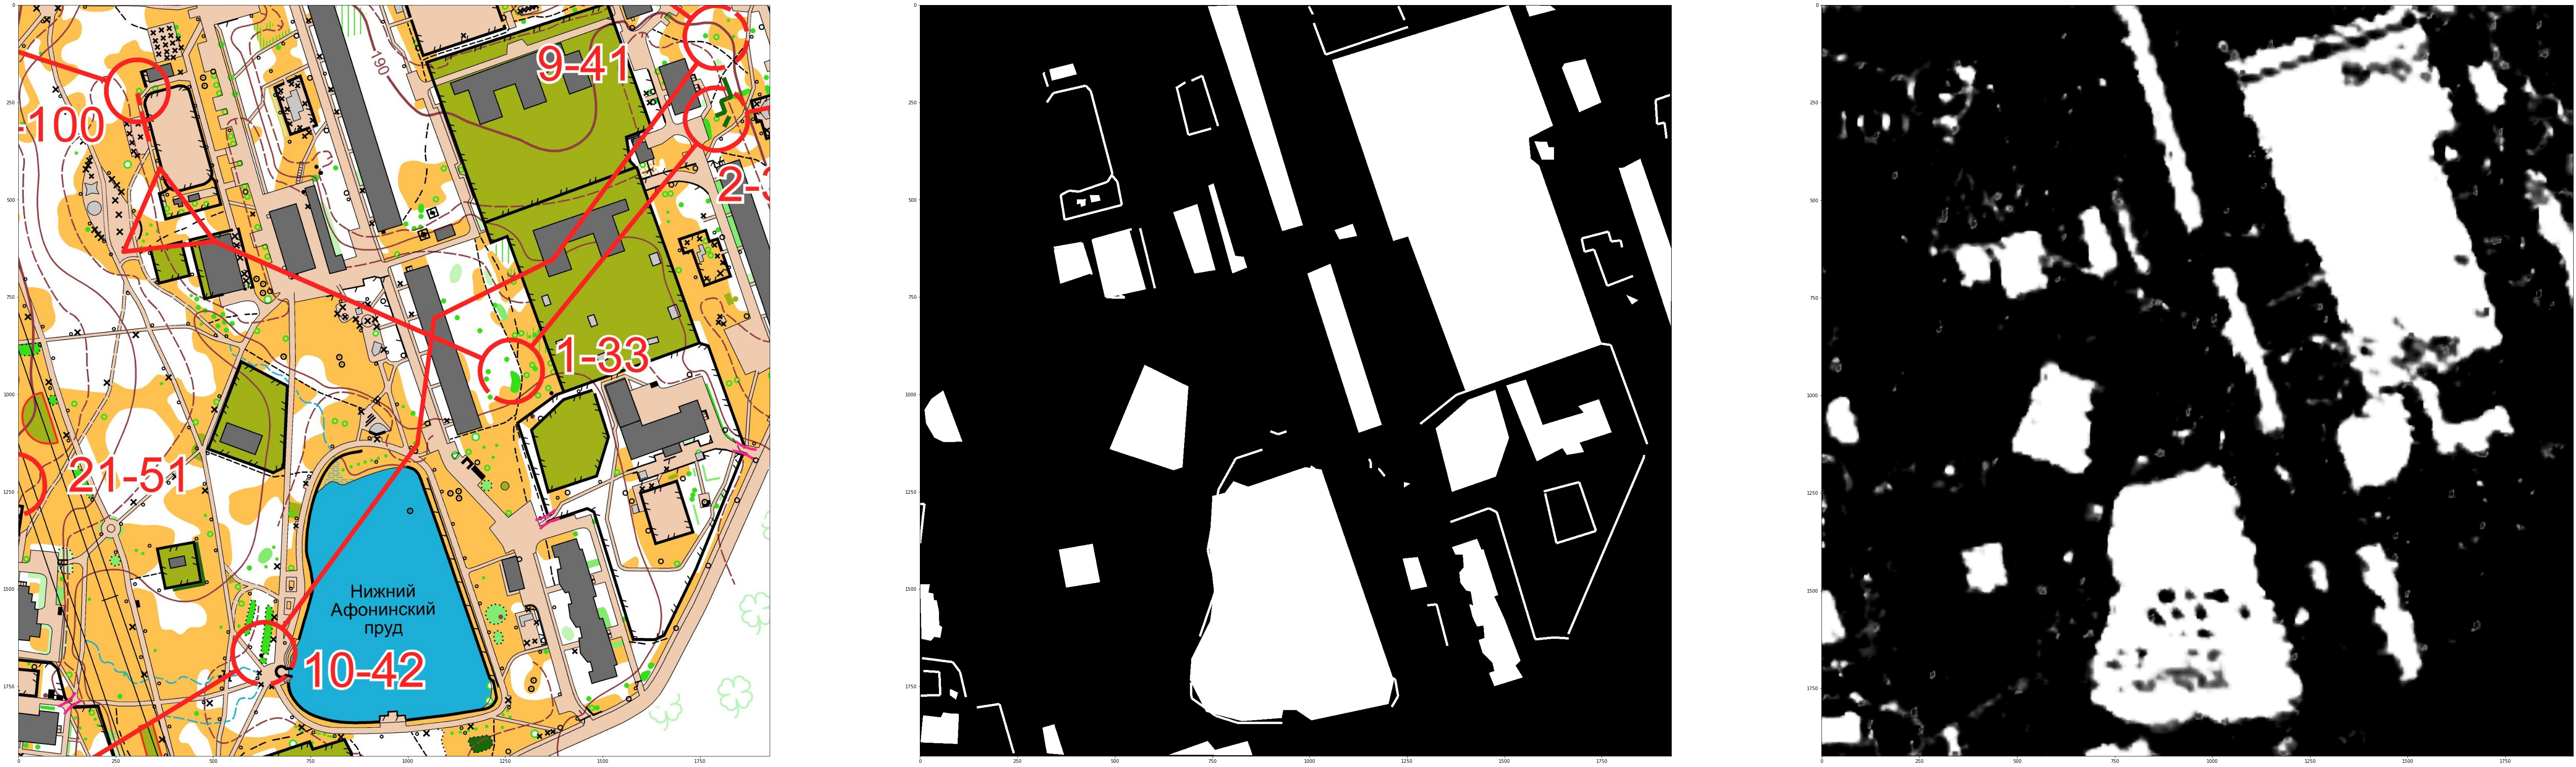

In [162]:
def draw_whole_map():
    name = 'MosVesna_2021_9_cont1_crop'
    pic = cv2.imread(name + '.jpg')
    labels = np.zeros(shape=(pic.shape[0], pic.shape[1]))
    b, g, r = cv2.split(pic)
    pic = cv2.merge([r, g, b])
    annotation = json.load(open(name + '.json', 'r'))
    pic = torch.tensor([prepare(pic)]).permute(0, 3, 1, 2).float()
    pred = model(pic)
    for i in range(0, pic.shape[2]):
        print(i, ' / ', pic.shape[2])
        for j in range(0, pic.shape[3]):
            for shape in annotation['shapes']:
                if detect(j, i, shape):
                    labels[i][j] = float(classnum(shape))
                    break
    fig = plt.figure(figsize=(100, 100))
    fig.add_subplot(1, 3, 1)
    plt.imshow(pic[0].permute(1, 2, 0).detach().numpy())
    fig.add_subplot(1, 3, 2)
    plt.imshow(labels, cmap='gray')
    fig.add_subplot(1, 3, 3)
    plt.imshow(pred.detach().numpy()[0][0], cmap='gray')
    plt.show()
draw_whole_map()